<a href="https://colab.research.google.com/github/lubaochuan/ml_python/blob/main/HOML_chapter_6_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chapter 6: Decision Trees (Fundamentals)

**Textbook:** *Hands-On Machine Learning (3rd ed.)*

This activity focuses on intuition: splitting, impurity, overfitting, and regularization.


## 0) Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_breast_cancer, make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score

np.random.seed(42)
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)


NumPy: 2.0.2
Pandas: 2.2.2


## 1) Explore a dataset: Iris (2 features)

We use two features so we can visualize splitting.

X shape: (150, 2)
Class counts: {0: 50, 1: 50, 2: 50}


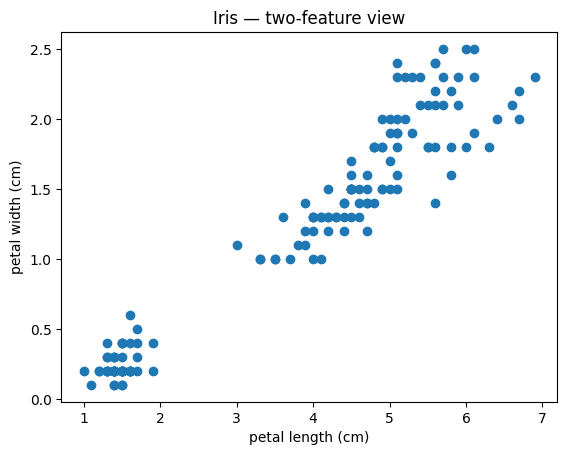

In [2]:
iris = load_iris(as_frame=True)
df = iris.frame.copy()
features = ['petal length (cm)', 'petal width (cm)']
X = df[features].to_numpy()
y = df['target'].to_numpy()
print('X shape:', X.shape)
print('Class counts:', pd.Series(y).value_counts().to_dict())
plt.figure()
plt.scatter(X[:,0], X[:,1])
plt.xlabel(features[0]); plt.ylabel(features[1])
plt.title('Iris — two-feature view')
plt.show()


### Review questions
1. What does each point represent?
2. What does it mean for a region to be “pure”?

**Your answers:**

## 2) Train a shallow decision tree

Test accuracy: 0.9473684210526315


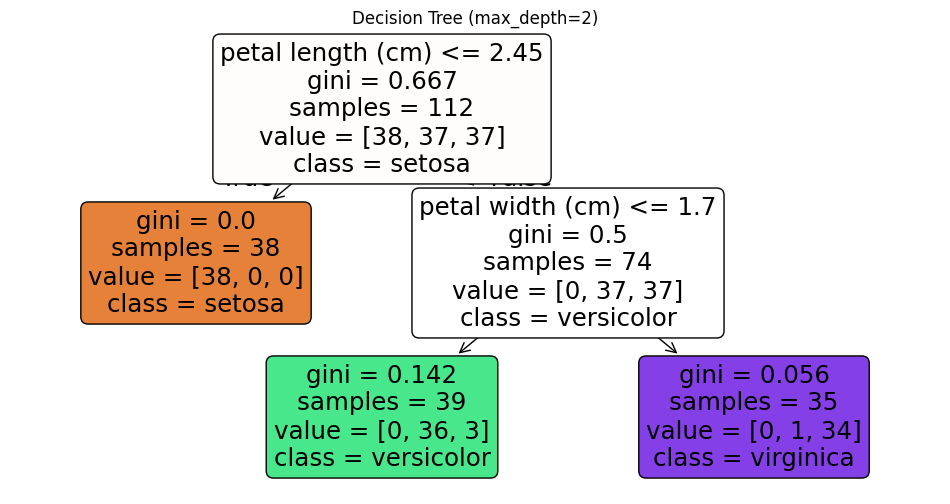

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_train, y_train)
pred = tree_clf.predict(X_test)
print('Test accuracy:', accuracy_score(y_test, pred))
plt.figure(figsize=(12,6))
plot_tree(tree_clf, feature_names=features, class_names=iris.target_names,
          filled=True, rounded=True)
plt.title('Decision Tree (max_depth=2)')
plt.show()


### Review questions
1. Which feature is used at the root?
2. What does `gini=0` indicate?

**Your answers:**

## 3) Impurity intuition: Gini vs Entropy

In [4]:
def gini(counts):
    counts = np.array(counts, dtype=float)
    p = counts / counts.sum()
    return 1.0 - np.sum(p**2)

def entropy(counts):
    counts = np.array(counts, dtype=float)
    p = counts / counts.sum()
    p = p[p>0]
    return -np.sum(p*np.log2(p))

examples = [([10,0,0],'Pure'), ([8,2,0],'Mostly one class'), ([4,3,3],'Mixed')]
rows=[]
for c,name in examples:
    rows.append((name,c, round(gini(c),3), round(entropy(c),3)))
pd.DataFrame(rows, columns=['Node','Counts','Gini','Entropy'])


,Node,Counts,Gini,Entropy
0,Pure,"[10, 0, 0]",0.00,-0.000
1,Mostly one class,"[8, 2, 0]",0.32,0.722
2,Mixed,"[4, 3, 3]",0.66,1.571


### Review questions
1. Which mix is most impure?
2. Why would reducing impurity help classification?

**Your answers:**

## 4) Overfitting: deep vs shallow (Iris)

In [5]:
deep_tree = DecisionTreeClassifier(random_state=42)
deep_tree.fit(X_train, y_train)
shallow_tree = DecisionTreeClassifier(max_depth=2, random_state=42)
shallow_tree.fit(X_train, y_train)
print('Deep   train/test:', deep_tree.score(X_train,y_train), deep_tree.score(X_test,y_test))
print('Shallow train/test:', shallow_tree.score(X_train,y_train), shallow_tree.score(X_test,y_test))


Deep   train/test: 0.9910714285714286 0.9210526315789473
Shallow train/test: 0.9642857142857143 0.9473684210526315


## 5) Boxy regions on nonlinear data (make_moons)

Train acc: 0.9083333333333333
Test acc: 0.945


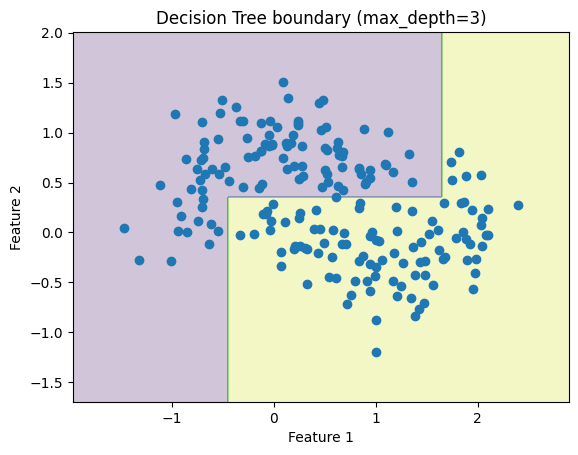

In [6]:
from sklearn.datasets import make_moons
X_m, y_m = make_moons(n_samples=800, noise=0.25, random_state=42)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(
    X_m, y_m, test_size=0.25, stratify=y_m, random_state=42)
tree_m = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_m.fit(Xm_train, ym_train)
print('Train acc:', tree_m.score(Xm_train, ym_train))
print('Test acc:', tree_m.score(Xm_test, ym_test))
def plot_decision_boundary(model, X, title):
    x0_min,x0_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    x1_min,x1_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx0,xx1 = np.meshgrid(np.linspace(x0_min,x0_max,300), np.linspace(x1_min,x1_max,300))
    grid = np.c_[xx0.ravel(), xx1.ravel()]
    Z = model.predict(grid).reshape(xx0.shape)
    plt.figure()
    plt.contourf(xx0, xx1, Z, alpha=0.25)
    plt.scatter(X[:,0], X[:,1])
    plt.title(title)
    plt.xlabel('Feature 1'); plt.ylabel('Feature 2')
    plt.show()
plot_decision_boundary(tree_m, Xm_test, 'Decision Tree boundary (max_depth=3)')


## 6) Regularization sweep: max_depth

Observe train vs test accuracy as depth increases.

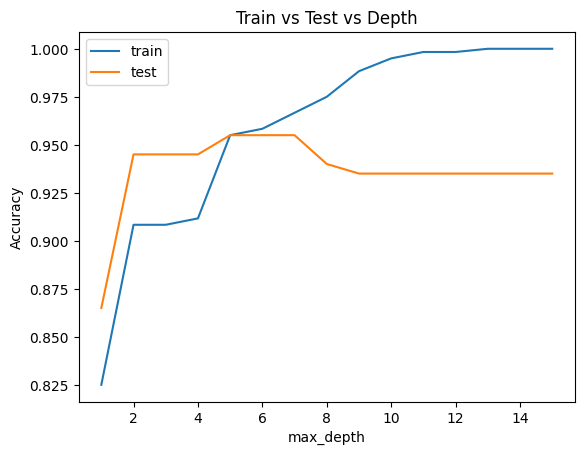

In [7]:
depths = list(range(1, 16))
train_scores=[]; test_scores=[]
for d in depths:
    m = DecisionTreeClassifier(max_depth=d, random_state=42)
    m.fit(Xm_train, ym_train)
    train_scores.append(m.score(Xm_train, ym_train))
    test_scores.append(m.score(Xm_test, ym_test))
plt.figure()
plt.plot(depths, train_scores, label='train')
plt.plot(depths, test_scores, label='test')
plt.xlabel('max_depth'); plt.ylabel('Accuracy')
plt.title('Train vs Test vs Depth')
plt.legend(); plt.show()


## 7) Feature importance (Breast Cancer)

Importances show which features reduced impurity the most (not causation).

In [8]:
bc = load_breast_cancer(as_frame=True)
X_bc = bc.data
y_bc = bc.target
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
    X_bc, y_bc, test_size=0.2, stratify=y_bc, random_state=42)
tree_bc = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_bc.fit(Xb_train, yb_train)
print('Train acc:', tree_bc.score(Xb_train, yb_train))
print('Test acc:', tree_bc.score(Xb_test, yb_test))
importances = pd.Series(tree_bc.feature_importances_, index=X_bc.columns).sort_values(ascending=False)
importances.head(10)


Train acc: 0.9868131868131869
Test acc: 0.9385964912280702


,0
worst radius,0.733548
worst concave points,0.122028
texture error,0.045785
worst texture,0.032319
worst concavity,0.017161
mean concave points,0.013327
area error,0.012704
mean texture,0.011846
worst symmetry,0.011282
mean area,0.000000


## Takeaways & reflection
1. Name two hyperparameters to reduce overfitting.
2. Why do trees tend to create boxy boundaries?
3. Why can feature importance be misleading?

**Your answers:**